<a href="https://colab.research.google.com/github/ParthBansal23/Mode-Collapse-in-GANs/blob/main/Mode_Collapse_in_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mode Collapse in GANs**


In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# Create utility functions
def get_generator(latent_size: int) -> nn.Module:
    """
    Returns the generator network.
    :param latent_size: (int) Size of the latent input vector
    :return: (nn.Module) Simple feed forward neural network
    """
    return nn.Sequential(nn.Linear(latent_size, 256, bias=True),
                         nn.LeakyReLU(),
                         nn.Linear(256, 256, bias=True),
                         nn.LeakyReLU(),
                         nn.Linear(256, 256, bias=True),
                         nn.LeakyReLU(),
                         nn.Linear(256, 256, bias=True),
                         nn.Tanh(),
                         nn.Linear(256, 2, bias=True))

def get_discriminator(use_spectral_norm: bool) -> nn.Module:
    """
    Returns the discriminator network.
    :param use_spectral_norm: (bool) If true spectral norm is utilized
    :return: (nn.Module) Simple feed forward neural network with probability output.
    """
    if use_spectral_norm:
        return nn.Sequential(spectral_norm(nn.Linear(2, 256, bias=True)),
                             nn.LeakyReLU(),
                             spectral_norm(nn.Linear(256, 256, bias=True)),
                             nn.LeakyReLU(),
                             spectral_norm(nn.Linear(256, 256, bias=True)),
                             nn.LeakyReLU(),
                             spectral_norm(nn.Linear(256, 256, bias=True)),
                             nn.LeakyReLU(),
                             spectral_norm(nn.Linear(256, 1, bias=True)))
    return nn.Sequential(nn.Linear(2, 256, bias=True),
                         nn.LeakyReLU(),
                         nn.Linear(256, 256, bias=True),
                         nn.LeakyReLU(),
                         nn.Linear(256, 256, bias=True),
                         nn.LeakyReLU(),
                         nn.Linear(256, 256, bias=True),
                         nn.LeakyReLU(),
                         nn.Linear(256, 1, bias=True))


In [3]:
def get_data(samples: int = 400, variance: float = 0.05) -> torch.Tensor:
    """
    Function generates a 2d ring of 8 Gaussians
    :param samples: (int) Number of samples. Must be a multiple of 8.
    :param variance: (float) Variance of the gaussian
    :return: (torch.Tensor) generated data
    """
    assert samples % 8 == 0 and samples > 0, "Number of samples must be a multiple of 8 and bigger than 0"
    # Init angels of the means
    angels = torch.cumsum((2 * np.pi / 8) * torch.ones((8)), dim=0)
    # Convert angles to 2D coordinates
    means = torch.stack([torch.cos(angels), torch.sin(angels)], dim=0)
    # Generate data
    data = torch.empty((2, samples))
    counter = 0
    for gaussian in range(means.shape[1]):
        for sample in range(int(samples / 8)):
            data[:, counter] = torch.normal(means[:, gaussian], variance)
            counter += 1
    # Reshape data
    data = data.T
    # Shuffle data
    data = data[torch.randperm(data.shape[0])]
    # Convert numpy array to tensor
    return data.float()

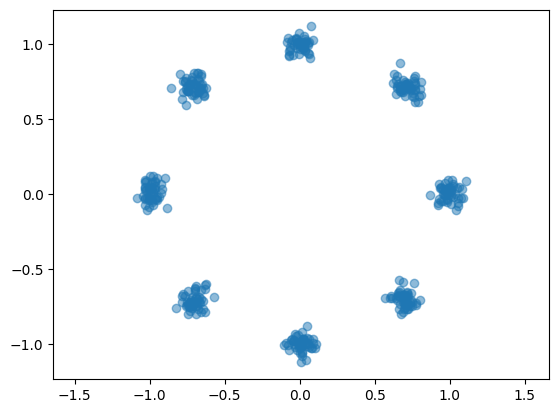

In [4]:
import matplotlib.pyplot as plt

data = get_data(samples=400, variance=0.05)

plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.axis("equal")
plt.show()

In [5]:
# Define loss functions
class GANLossGenerator(nn.Module):
    """Standard generator GAN loss"""
    def __init__(self) -> None:
        super(GANLossGenerator, self).__init__()

    def forward(self, discriminator_prediction_fake: torch.Tensor, **kwargs) -> torch.Tensor:
        return - torch.nn.functional.softplus(discriminator_prediction_fake).mean()

class GANLossDiscriminator(nn.Module):
    """Standard discriminator GAN loss"""
    def __init__(self) -> None:
        super(GANLossDiscriminator, self).__init__()

    def forward(self, discriminator_prediction_real: torch.Tensor,
                discriminator_prediction_fake: torch.Tensor, **kwargs) -> torch.Tensor:
        return torch.nn.functional.softplus(- discriminator_prediction_real).mean() \
               + torch.nn.functional.softplus(discriminator_prediction_fake).mean()

class NSGANLossGenerator(nn.Module):
    """Non-saturating generator GAN loss"""
    def __init__(self) -> None:
        super(NSGANLossGenerator, self).__init__()

    def forward(self, discriminator_prediction_fake: torch.Tensor, **kwargs) -> torch.Tensor:
        return torch.nn.functional.softplus(- discriminator_prediction_fake).mean()

class NSGANLossDiscriminator(GANLossDiscriminator):
    """Non-saturating discriminator GAN loss"""
    def __init__(self) -> None:
        super(NSGANLossDiscriminator, self).__init__()

class WassersteinGANLossGenerator(nn.Module):
    """Wasserstein generator GAN loss"""
    def __init__(self) -> None:
        super(WassersteinGANLossGenerator, self).__init__()

    def forward(self, discriminator_prediction_fake: torch.Tensor, **kwargs) -> torch.Tensor:
        return - discriminator_prediction_fake.mean()

class WassersteinGANLossDiscriminator(nn.Module):
    """Wasserstein discriminator GAN loss"""
    def __init__(self) -> None:
        super(WassersteinGANLossDiscriminator, self).__init__()

    def forward(self, discriminator_prediction_real: torch.Tensor,
                discriminator_prediction_fake: torch.Tensor, **kwargs) -> torch.Tensor:
        return - discriminator_prediction_real.mean() \
               + discriminator_prediction_fake.mean()

class WassersteinGANLossGPDiscriminator(nn.Module):
    """Wasserstein discriminator GAN loss with gradient penalty"""
    def __init__(self) -> None:
        super(WassersteinGANLossGPDiscriminator, self).__init__()

    def forward(self, discriminator_prediction_real: torch.Tensor,
                discriminator_prediction_fake: torch.Tensor,
                discriminator: nn.Module,
                real_samples: torch.Tensor,
                fake_samples: torch.Tensor,
                lambda_gradient_penalty: float = 2., **kwargs) -> torch.Tensor:
        # Generate random alpha for interpolation
        alpha = torch.rand((real_samples.shape[0], 1), device=real_samples.device)
        # Make interpolated samples
        samples_interpolated = (alpha * real_samples + (1. - alpha) * fake_samples)
        samples_interpolated.requires_grad = True
        # Make discriminator prediction
        discriminator_prediction_interpolated = discriminator(samples_interpolated)
        # Calc gradients
        gradients = torch.autograd.grad(outputs=discriminator_prediction_interpolated.sum(),
                                        inputs=samples_interpolated,
                                        create_graph=True,
                                        retain_graph=True)[0]
        # Calc gradient penalty
        gradient_penalty = (gradients.view(gradients.shape[0], -1).norm(dim=1) - 1.).pow(2).mean()
        return - discriminator_prediction_real.mean() \
               + discriminator_prediction_fake.mean() \
               + lambda_gradient_penalty * gradient_penalty

In [6]:
# Define metrics for mode collapse
def calculate_mode_coverage(generated_samples, real_data, n_modes=8, threshold=0.2):
    """
    Calculate how many of the 8 modes are covered by generated samples
    """
    # Calculate centers of the 8 modes
    angels = torch.cumsum((2 * np.pi / 8) * torch.ones((8)), dim=0)
    centers = torch.stack([torch.cos(angels), torch.sin(angels)], dim=1)

    # Convert to numpy if tensors
    if isinstance(generated_samples, torch.Tensor):
        generated_samples = generated_samples.cpu().detach().numpy()
    if isinstance(centers, torch.Tensor):
        centers = centers.cpu().detach().numpy()

    # Check for each mode if there's at least one sample close to it
    modes_covered = 0
    for center in centers:
        distances = np.sqrt(np.sum((generated_samples - center)**2, axis=1))
        if np.min(distances) < threshold:
            modes_covered += 1

    return modes_covered, modes_covered / n_modes

In [7]:

def calculate_kl_divergence(generated_samples, real_data, n_modes=8):
    """
    Calculate estimated KL divergence between generated and real distributions
    Based on mode assignment
    """
    # Calculate centers of the 8 modes
    angels = torch.cumsum((2 * np.pi / 8) * torch.ones((8)), dim=0)
    centers = torch.stack([torch.cos(angels), torch.sin(angels)], dim=1)

    # Convert to numpy if tensors
    if isinstance(generated_samples, torch.Tensor):
        generated_samples = generated_samples.cpu().detach().numpy()
    if isinstance(real_data, torch.Tensor):
        real_data = real_data.cpu().detach().numpy()
    if isinstance(centers, torch.Tensor):
        centers = centers.cpu().detach().numpy()

    # Count samples per mode
    real_mode_counts = np.zeros(n_modes)
    gen_mode_counts = np.zeros(n_modes)

    # Assign real data to modes
    for sample in real_data:
        distances = np.sqrt(np.sum((centers - sample)**2, axis=1))
        closest_mode = np.argmin(distances)
        real_mode_counts[closest_mode] += 1

    # Assign generated data to modes
    for sample in generated_samples:
        distances = np.sqrt(np.sum((centers - sample)**2, axis=1))
        closest_mode = np.argmin(distances)
        gen_mode_counts[closest_mode] += 1

    # Normalize to get probabilities
    real_probs = real_mode_counts / np.sum(real_mode_counts)
    gen_probs = gen_mode_counts / np.sum(gen_mode_counts)

    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    real_probs = real_probs + epsilon
    real_probs = real_probs / np.sum(real_probs)
    gen_probs = gen_probs + epsilon
    gen_probs = gen_probs / np.sum(gen_probs)

    # Calculate KL divergence
    kl_div = np.sum(real_probs * np.log(real_probs / gen_probs))
    return kl_div

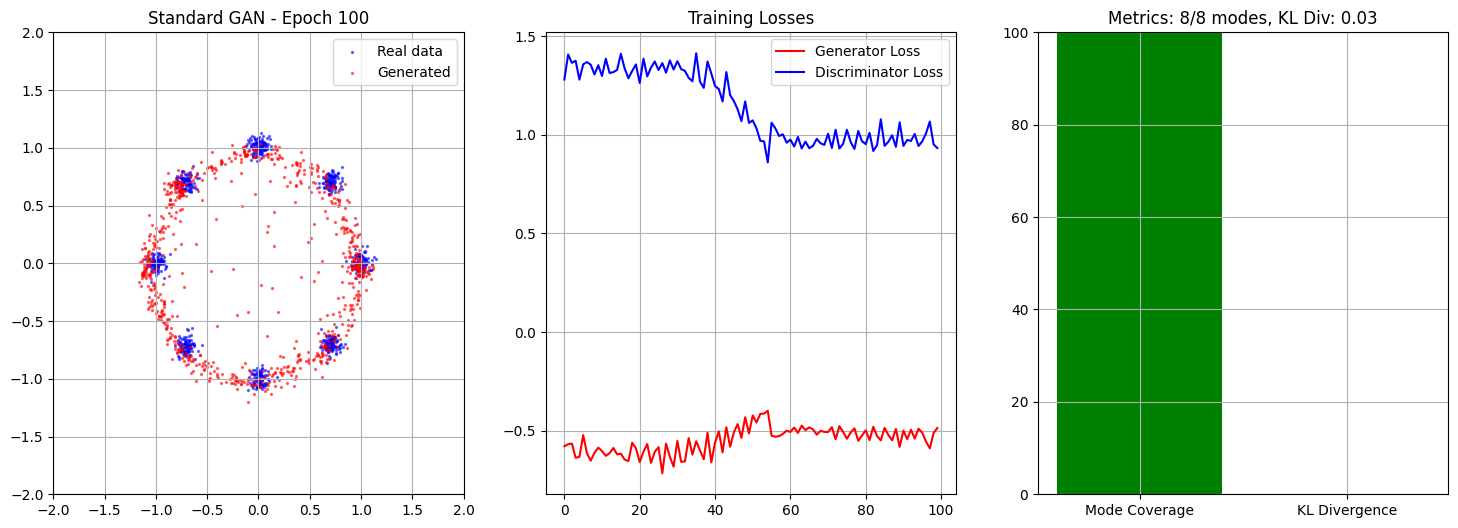

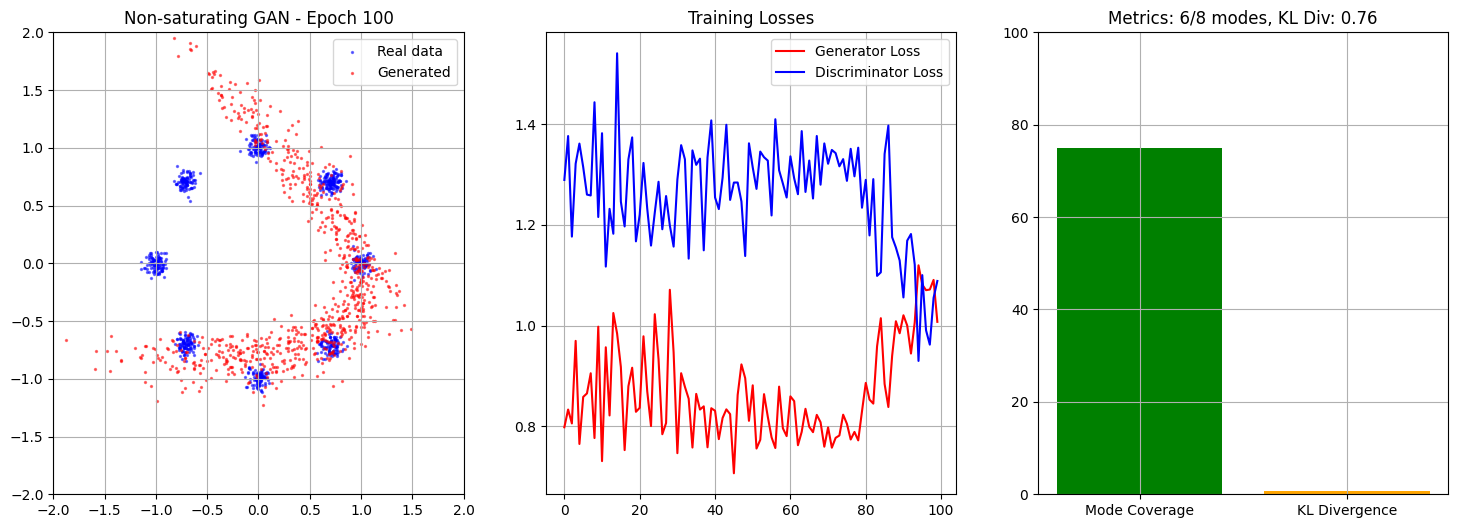

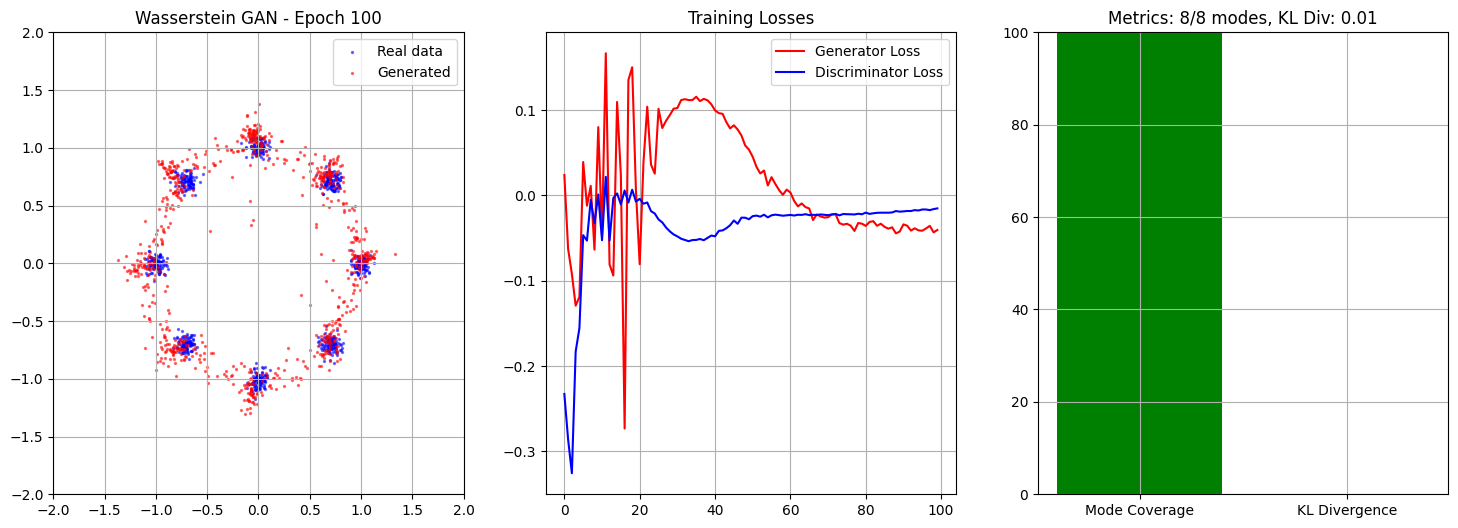

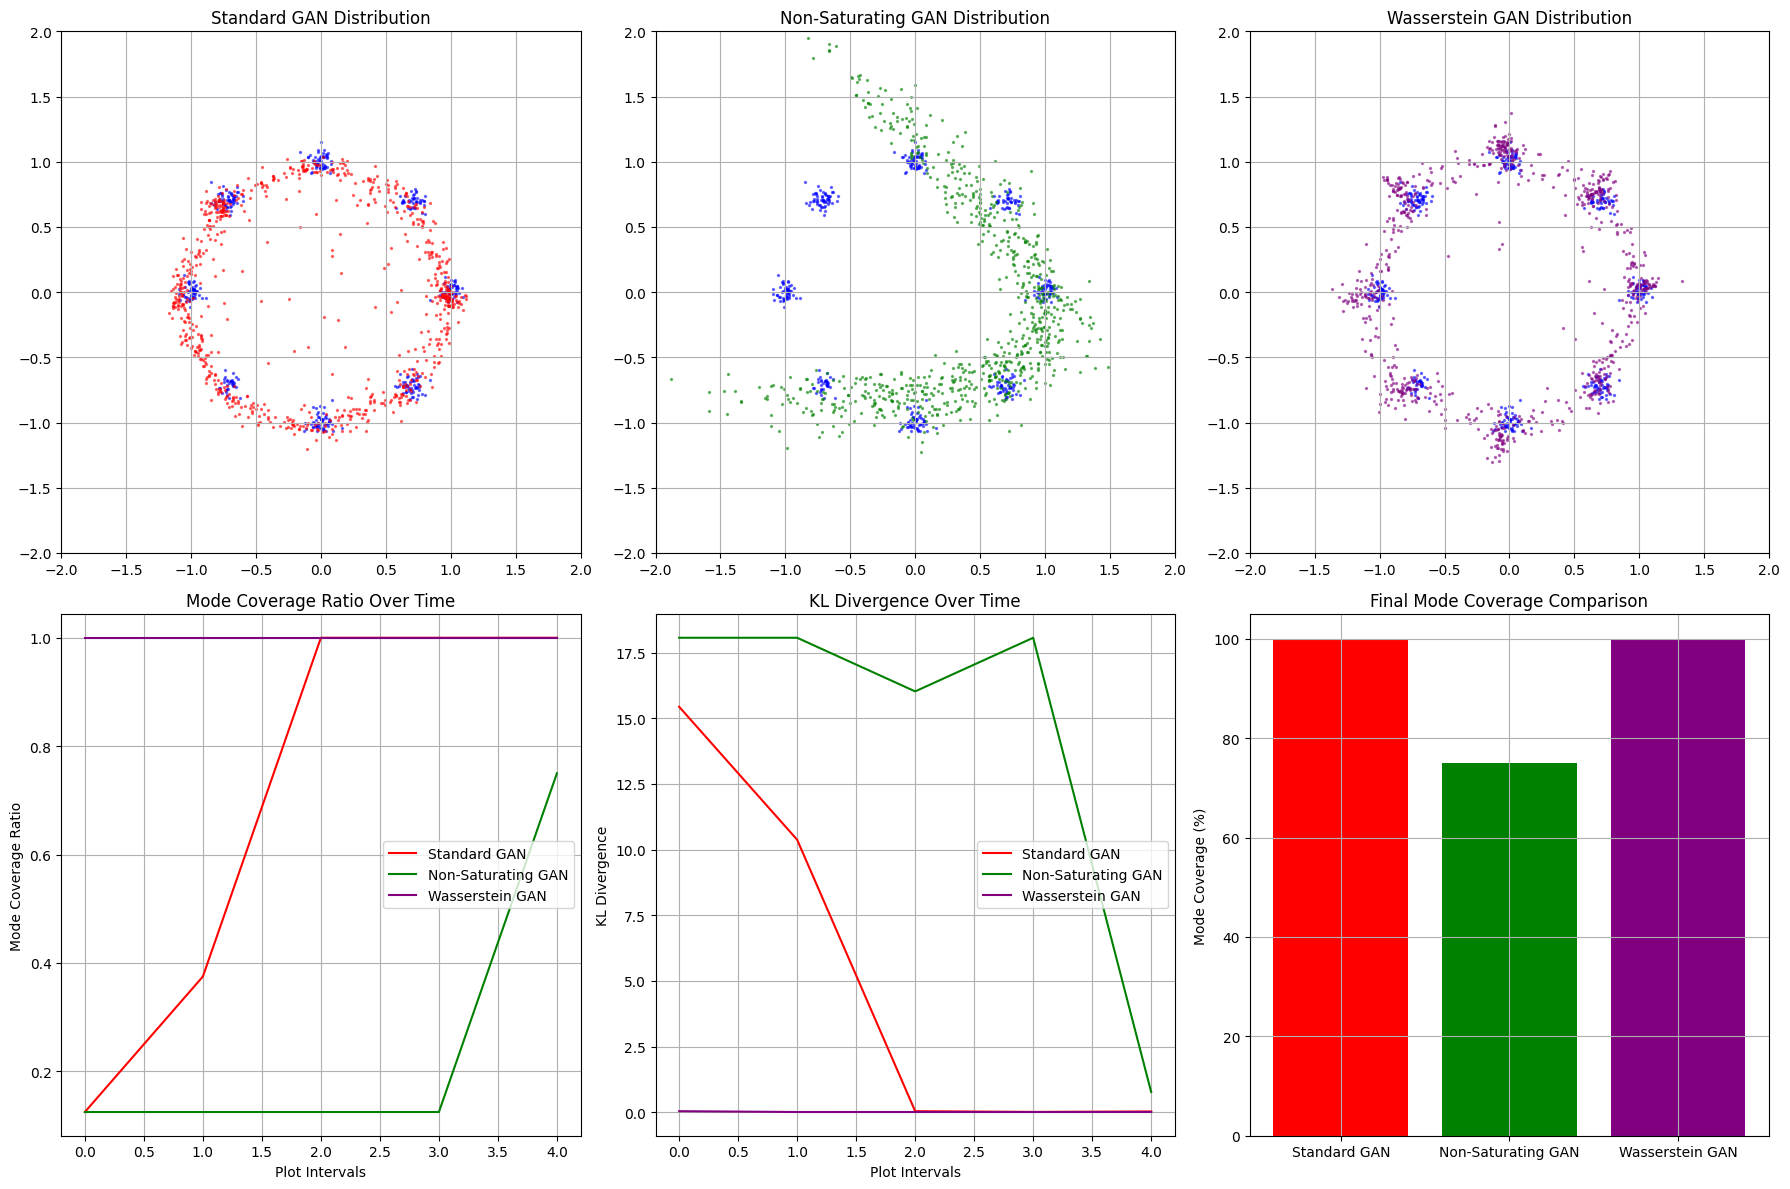


Creating animations to show mode collapse progression...



Final Mode Coverage Comparison:
Standard GAN: 100.0% of modes covered
Non-Saturating GAN: 75.0% of modes covered
Wasserstein GAN: 100.0% of modes covered

Final KL Divergence Comparison:
Standard GAN: 0.03
Non-Saturating GAN: 0.76
Wasserstein GAN: 0.01


In [8]:

# Main training function
def train_and_visualize_gan(loss_type='standard', epochs=500, device='cpu', plot_frequency=10):
    """
    Train a GAN with the specified loss function and visualize the results
    """
    # Parameters
    latent_size = 32
    samples = 8000
    batch_size = 400
    d_updates = 1
    lr = 0.0001
    spectral_norm = False if loss_type != 'wasserstein' else True
    clip_weights = 0.01 if loss_type == 'wasserstein' else 0.0

    # Get data, generator, and discriminator
    real_data = get_data(samples=samples).to(device)
    generator = get_generator(latent_size=latent_size).to(device)
    discriminator = get_discriminator(use_spectral_norm=spectral_norm).to(device)

    # Fixed noise for visualization
    fixed_generator_noise = torch.randn([samples // 10, latent_size], device=device)

    # Initialize loss function based on the chosen loss type
    if loss_type == 'standard':
        loss_generator = GANLossGenerator().to(device)
        loss_discriminator = GANLossDiscriminator().to(device)
    elif loss_type == 'non-saturating':
        loss_generator = NSGANLossGenerator().to(device)
        loss_discriminator = NSGANLossDiscriminator().to(device)
    elif loss_type == 'wasserstein':
        loss_generator = WassersteinGANLossGenerator().to(device)
        loss_discriminator = WassersteinGANLossDiscriminator().to(device)
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

    # Optimizers
    generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr)
    discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

    # Lists to store metrics
    generator_losses = []
    discriminator_losses = []
    mode_coverage_ratios = []
    kl_divergences = []

    # Training loop with visualization
    fig = plt.figure(figsize=(18, 6))
    plt.ion()  # Enable interactive mode

    # For FID plot later
    all_fake_samples = []

    # Progress bar
    with tqdm(total=epochs) as progress_bar:
        for epoch in range(epochs):
            epoch_g_loss = 0
            epoch_d_loss = 0
            batches = 0

            # Train on batches
            for index in range(0, samples, batch_size):
                real_data = real_data[torch.randperm(real_data.shape[0], device=device)]

                # Train discriminator
                for _ in range(d_updates):
                    batch = real_data[index:index + batch_size]
                    noise = torch.randn([batch_size, latent_size], device=device)

                    discriminator_optimizer.zero_grad()

                    with torch.no_grad():
                        fake_samples = generator(noise)

                    prediction_real = discriminator(batch)
                    prediction_fake = discriminator(fake_samples)

                    if isinstance(loss_discriminator, WassersteinGANLossGPDiscriminator):
                        loss_d = loss_discriminator(prediction_real, prediction_fake,
                                                    discriminator, batch, fake_samples)
                    else:
                        loss_d = loss_discriminator(prediction_real, prediction_fake)

                    loss_d.backward()
                    discriminator_optimizer.step()

                    # Clip weights for Wasserstein GAN
                    if clip_weights > 0:
                        with torch.no_grad():
                            for param in discriminator.parameters():
                                param.clamp_(-clip_weights, clip_weights)

                # Train generator
                noise = torch.randn([batch_size, latent_size], device=device)

                generator_optimizer.zero_grad()

                fake_samples = generator(noise)
                prediction_fake = discriminator(fake_samples)

                loss_g = loss_generator(prediction_fake)

                loss_g.backward()
                generator_optimizer.step()

                epoch_g_loss += loss_g.item()
                epoch_d_loss += loss_d.item()
                batches += 1

            # Record average losses
            avg_g_loss = epoch_g_loss / batches
            avg_d_loss = epoch_d_loss / batches
            generator_losses.append(avg_g_loss)
            discriminator_losses.append(avg_d_loss)

            # Update progress bar
            progress_bar.set_description(
                f'Loss [{loss_type}]: G={avg_g_loss:.4f}, D={avg_d_loss:.4f}'
            )
            progress_bar.update(1)

            # Visualize periodically
            if (epoch + 1) % plot_frequency == 0 or epoch == epochs - 1:
                with torch.no_grad():
                    generator.eval()
                    generator_samples = generator(fixed_generator_noise).cpu().detach()
                    all_fake_samples.append(generator_samples.numpy())

                    # Calculate metrics
                    modes_covered, coverage_ratio = calculate_mode_coverage(
                        generator_samples, real_data
                    )
                    mode_coverage_ratios.append(coverage_ratio)

                    kl_div = calculate_kl_divergence(generator_samples, real_data)
                    kl_divergences.append(kl_div)

                    # Update plots
                    plt.clf()

                    # Data distribution plot
                    plt.subplot(1, 3, 1)
                    plt.scatter(real_data[::10, 0].cpu(), real_data[::10, 1].cpu(),
                                color='blue', label='Real data', s=2, alpha=0.5)
                    plt.scatter(generator_samples[:, 0], generator_samples[:, 1],
                                color='red', label='Generated', s=2, alpha=0.5)
                    plt.legend(loc='upper right')
                    plt.title(f'{loss_type.capitalize()} GAN - Epoch {epoch+1}')
                    plt.xlim((-2, 2))
                    plt.ylim((-2, 2))
                    plt.grid(True)

                    # Loss plot
                    plt.subplot(1, 3, 2)
                    plt.plot(generator_losses, label='Generator Loss', color='red')
                    plt.plot(discriminator_losses, label='Discriminator Loss', color='blue')
                    plt.legend()
                    plt.title('Training Losses')
                    plt.grid(True)

                    # Mode coverage
                    plt.subplot(1, 3, 3)
                    plt.bar(['Mode Coverage', 'KL Divergence'],
                            [coverage_ratio * 100, min(5, kl_div)],
                            color=['green', 'orange'])
                    plt.title(f'Metrics: {modes_covered}/8 modes, KL Div: {kl_div:.2f}')
                    plt.ylim(0, 100)
                    plt.grid(True)

                    display(plt.gcf())
                    clear_output(wait=True)

                    generator.train()

    # Return final metrics for comparison
    return {
        'loss_type': loss_type,
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'mode_coverage_ratios': mode_coverage_ratios,
        'kl_divergences': kl_divergences,
        'final_samples': all_fake_samples[-1],
        'all_samples': all_fake_samples
    }

# Function to compare different GANs
def compare_gan_methods():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Train all three GANs
    print("Training Standard GAN...")
    standard_results = train_and_visualize_gan('standard', epochs=100, device=device, plot_frequency=20)

    print("\nTraining Non-Saturating GAN...")
    ns_results = train_and_visualize_gan('non-saturating', epochs=100, device=device, plot_frequency=20)

    print("\nTraining Wasserstein GAN...")
    wgan_results = train_and_visualize_gan('wasserstein', epochs=100, device=device, plot_frequency=20)

    # Comparison visualization
    plt.figure(figsize=(18, 12))

    # Plot final distributions
    plt.subplot(2, 3, 1)
    real_data = get_data(samples=8000)
    plt.scatter(real_data[::20, 0], real_data[::20, 1], color='blue', label='Real data', s=2, alpha=0.5)
    plt.scatter(standard_results['final_samples'][:, 0], standard_results['final_samples'][:, 1],
                color='red', label='Standard GAN', s=2, alpha=0.5)
    plt.title('Standard GAN Distribution')
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.scatter(real_data[::20, 0], real_data[::20, 1], color='blue', label='Real data', s=2, alpha=0.5)
    plt.scatter(ns_results['final_samples'][:, 0], ns_results['final_samples'][:, 1],
                color='green', label='Non-Saturating GAN', s=2, alpha=0.5)
    plt.title('Non-Saturating GAN Distribution')
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.scatter(real_data[::20, 0], real_data[::20, 1], color='blue', label='Real data', s=2, alpha=0.5)
    plt.scatter(wgan_results['final_samples'][:, 0], wgan_results['final_samples'][:, 1],
                color='purple', label='Wasserstein GAN', s=2, alpha=0.5)
    plt.title('Wasserstein GAN Distribution')
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.grid(True)

    # Plot mode coverage over time
    plt.subplot(2, 3, 4)
    plt.plot(standard_results['mode_coverage_ratios'], color='red', label='Standard GAN')
    plt.plot(ns_results['mode_coverage_ratios'], color='green', label='Non-Saturating GAN')
    plt.plot(wgan_results['mode_coverage_ratios'], color='purple', label='Wasserstein GAN')
    plt.title('Mode Coverage Ratio Over Time')
    plt.xlabel('Plot Intervals')
    plt.ylabel('Mode Coverage Ratio')
    plt.legend()
    plt.grid(True)

    # Plot KL divergence over time
    plt.subplot(2, 3, 5)
    plt.plot(standard_results['kl_divergences'], color='red', label='Standard GAN')
    plt.plot(ns_results['kl_divergences'], color='green', label='Non-Saturating GAN')
    plt.plot(wgan_results['kl_divergences'], color='purple', label='Wasserstein GAN')
    plt.title('KL Divergence Over Time')
    plt.xlabel('Plot Intervals')
    plt.ylabel('KL Divergence')
    plt.legend()
    plt.grid(True)

    # Plot final mode coverage comparison
    plt.subplot(2, 3, 6)
    plt.bar(['Standard GAN', 'Non-Saturating GAN', 'Wasserstein GAN'],
            [standard_results['mode_coverage_ratios'][-1]*100,
             ns_results['mode_coverage_ratios'][-1]*100,
             wgan_results['mode_coverage_ratios'][-1]*100],
            color=['red', 'green', 'purple'])
    plt.title('Final Mode Coverage Comparison')
    plt.ylabel('Mode Coverage (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Create animation of the learning process
    def create_animation(results, title):
        fig, ax = plt.subplots(figsize=(8, 8))

        def update(i):
            ax.clear()
            real_data = get_data(samples=8000)
            ax.scatter(real_data[::20, 0], real_data[::20, 1], color='blue', label='Real data', s=2, alpha=0.5)
            ax.scatter(results['all_samples'][i][:, 0], results['all_samples'][i][:, 1],
                      color='red', label='Generated', s=2, alpha=0.5)
            ax.set_title(f'{title} - Learning Progress')
            ax.set_xlim((-2, 2))
            ax.set_ylim((-2, 2))
            ax.grid(True)
            ax.legend()

        anim = FuncAnimation(fig, update, frames=len(results['all_samples']), interval=300)
        plt.close(fig)
        return anim

    print("\nCreating animations to show mode collapse progression...")

    # Show animations for all three GANs
    anim1 = create_animation(standard_results, 'Standard GAN')
    display(HTML(anim1.to_jshtml()))

    anim2 = create_animation(ns_results, 'Non-Saturating GAN')
    display(HTML(anim2.to_jshtml()))

    anim3 = create_animation(wgan_results, 'Wasserstein GAN')
    display(HTML(anim3.to_jshtml()))

    # Final summary
    print("\nFinal Mode Coverage Comparison:")
    print(f"Standard GAN: {standard_results['mode_coverage_ratios'][-1]*100:.1f}% of modes covered")
    print(f"Non-Saturating GAN: {ns_results['mode_coverage_ratios'][-1]*100:.1f}% of modes covered")
    print(f"Wasserstein GAN: {wgan_results['mode_coverage_ratios'][-1]*100:.1f}% of modes covered")

    print("\nFinal KL Divergence Comparison:")
    print(f"Standard GAN: {standard_results['kl_divergences'][-1]:.2f}")
    print(f"Non-Saturating GAN: {ns_results['kl_divergences'][-1]:.2f}")
    print(f"Wasserstein GAN: {wgan_results['kl_divergences'][-1]:.2f}")

# Run the full comparison
if __name__ == "__main__":

    compare_gan_methods()

# Reference

https://github.com/ChristophReich1996/Mode_Collapse